In [1]:
import pandas as pd
import numpy as np

import cv2
import os

from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
video_properties = []
raw_data_dir = "data/raw"
pbar = tqdm(os.listdir(raw_data_dir))

for file in pbar:
    capture = cv2.VideoCapture(os.path.join(raw_data_dir, file))

    num_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    vid_fps = int(capture.get(cv2.CAP_PROP_FPS))

    vid_length = (num_frames / vid_fps) / 60
    video_properties.append([file, num_frames, vid_fps, vid_length])

meta_data = pd.DataFrame(
    video_properties, 
    columns = ["video_name", "frame_count", "fps", "video_length"],
).set_index("video_name")

print(meta_data.shape)
meta_data.head()

100%|██████████| 39/39 [00:00<00:00, 39.06it/s]

(39, 3)


,frame_count,fps,video_length
video_name,,,
20240602 212200 [FCtTboJZqRo].mp4,35910,30,19.950000
20240602 214212 [NnB1-UF8uLg].mp4,34013,30,18.896111
20240602 220107 [OyLe-Z-knPU].mp4,27811,30,15.450556
20240602 221937 [-YONig2XS1E].mp4,36293,30,20.162778
20240730 131005 [jxA1l8uesMw].mp4,38952,30,21.640000


In [3]:
# Try background estimation on a random video

filename = meta_data.index[11]
capture = cv2.VideoCapture(os.path.join(raw_data_dir, filename))

# Use only the first 1000 frames for testing
video_array = np.zeros(shape = (360, 640, 3, 1000), dtype = np.uint8)

idx = 0
while capture.isOpened():
    ret, frame = capture.read()
    if not ret:
        break

    video_array[:, :, :, idx] = frame
    idx += 1
    
    if idx >= 1000:
        break

video_array.shape

(360, 640, 3, 1000)

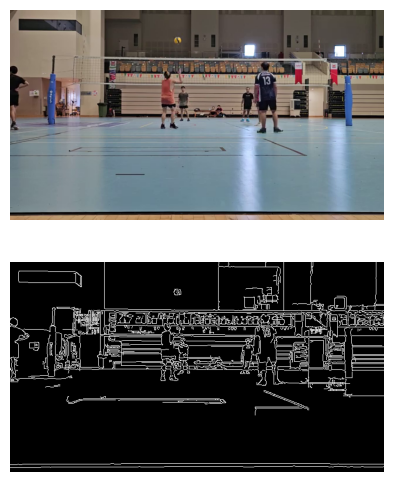

In [4]:
import matplotlib.pyplot as plt
from src.utils import stream_video, plot_image

frame = video_array[:, :, :, 194]
edges = cv2.Canny(frame, 10, 400)

fig, (top, bot) = plt.subplots(nrows = 2, ncols = 1, figsize = (8, 6))

plot_image(frame, (fig, top))
plot_image(edges, (fig, bot))

plt.show()

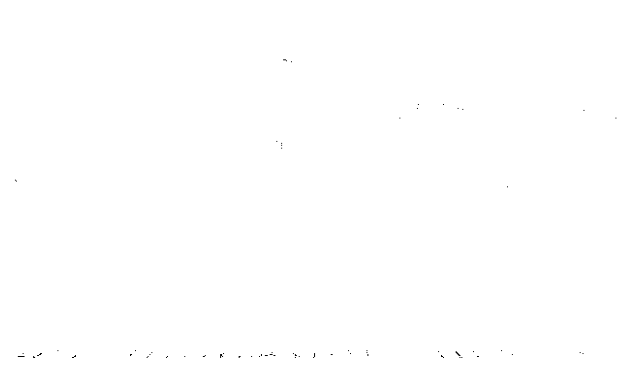

In [5]:
ball_yellow = (166, 127, 30)

channel_B = frame[:, :, 0]
channel_G = frame[:, :, 1]
channel_R = frame[:, :, 2]

minus_yellow = np.stack([
    channel_B - ball_yellow[2],
    channel_G - ball_yellow[1],
    channel_R - ball_yellow[0],
], axis = -1)

ret, mask = cv2.threshold(
    cv2.cvtColor(minus_yellow, cv2.COLOR_BGR2GRAY), 
    10, 
    255,
    cv2.THRESH_BINARY
)
plot_image(mask, mode = "gray")
plt.show()

2


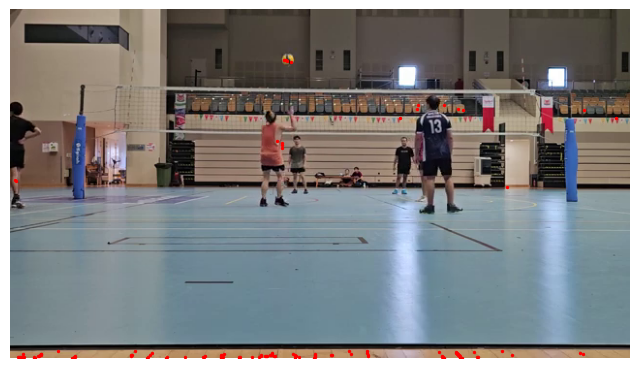

In [6]:
locs = np.where(mask < 50)
print(len(locs))

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)

plot_image(frame, (fig, ax))
ax.scatter(locs[1], locs[0], color = "red", s = 2)
plt.show()

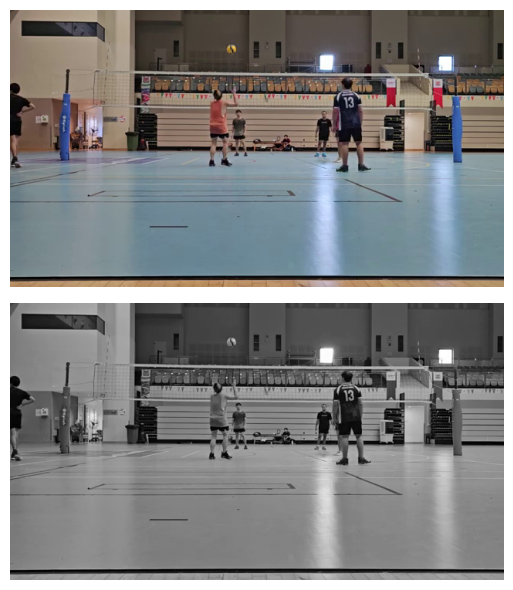

In [7]:
grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

fig, (top, bot) = plt.subplots(nrows = 2, ncols = 1, figsize = (8, 6))

plot_image(frame, (fig, top))
plot_image(grayscale, (fig, bot), mode = "gray")

plt.tight_layout()
plt.show()

In [9]:
import torch
import yaml

import warnings
warnings.simplefilter("ignore")

yolov5 = torch.hub.load("ultralytics/yolov5", "custom", "yolov5/weights/yolov5s.pt")
name_dict = yaml.safe_load(open("yolov5/data/coco.yaml", "r"))["names"]

model_preds = []
for i in range(200):
    frame = video_array[:, :, :, 100 + i]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = yolov5(frame)
    model_preds.append(results.xyxyn)

Using cache found in C:\Users\Clifford_PP/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-1-4 Python-3.10.16 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [14]:
frames_with_ball = []
for i, preds in enumerate(model_preds):
    for name_id in preds[0][:, -1]:
        if name_id != 62:
            continue
        frames_with_ball.append(i)

stream_video(video_array[:, :, :, frames_with_ball])